In [1]:
import carla
import signals_gen 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import asyncio

In [2]:
dt = 0.005
sync = True
render = True

carla_port = 2000
carla_town = 'Town04'

vehicle_model = 'vehicle.tesla.model3'

In [3]:
# Connect the client and set up bp library and spawn points
client = carla.Client('localhost', carla_port) 
client.set_timeout(12.0) 

world = client.get_world()

settings = world.get_settings()
settings.no_rendering_mode = not render
settings.fixed_delta_seconds = dt
settings.synchronous_mode = sync
world.apply_settings(settings)
world = client.load_world(carla_town, reset_settings=False)

In [4]:
df = pd.read_csv('C:/custom_carla/carla/PythonAPI/AggressiveDrivingSignals/parameters_exploration/FTP-75-cycle/FTP-75.csv')
df.drop(index=0, inplace=True, axis=0)
df = df.dropna(axis='index')
df['Phase'] = df['Phase'].astype(int)
df = df[(df['Phase'] == 1) | (df['Phase'] == 2)]
df.drop('Phase', inplace=True, axis=1)

ftp_v = np.array(df['Set Spd'], dtype=float)
ftp_t = np.array(df['Time'], dtype=float)
# converting from mph to km/h
ftp_v = 1.60934 * ftp_v

In [5]:
bp_lib = world.get_blueprint_library() 
spawn_points = world.get_map().get_spawn_points() 
vehicle = world.try_spawn_actor(bp_lib.find(vehicle_model), spawn_points[134])

In [6]:
# route_ids = [75,100,92,272,134,138,130,296,222,212,139,352,336]
route_ids = [75,100,92,272]
waypoints = [spawn_points[idx] for idx in route_ids]

# Draw only the spawn points locations that are part of the route
for idx in route_ids:
    world.debug.draw_string(spawn_points[idx].location, str(idx), life_time=15, color=carla.Color(255,0,0))

In [7]:
filename = 'test.csv'

In [13]:
gen = signals_gen.ADSGenerator(world, vehicle, waypoints, target_aggIn=150)

In [14]:
await gen.sim(max_duration=60, filename=filename, speed_profile=ftp_v, stop_at_end_pos=False)

         the time required to complete the path chosen, the vehicle's route could be uncertain. By default the vehicle
         should try to keep its lane on the main route.
NOTE: choosing a main street route, this could be useful for long simulation if you want the vehicle to keep running on the same path.
Operation confirmed.
Starting initialization cycle...
Initialization cycle completed!
Starting simulation...
Main loop completed!
Exiting save task!
Simulation completed!


In [15]:
signals_df = pd.read_csv(filename, sep=',', header=0)
x_t = np.array(signals_df['Time'], dtype=float)
y_rv = np.array(signals_df['Velocity'], dtype=float)
y_tv = np.array(signals_df['Target Velocity'], dtype=float)
y_tp = np.array(signals_df['Throttle'], dtype=float)
y_bp = np.array(signals_df['Brake'], dtype=float)
acc_x = np.array(signals_df['AccX'], dtype=float)
acc_y = np.array(signals_df['AccY'], dtype=float)
acc_z = np.array(signals_df['AccZ'], dtype=float)
gyro_x = np.array(signals_df['GyroX'], dtype=float)
gyro_y = np.array(signals_df['GyroY'], dtype=float)
gyro_z = np.array(signals_df['GyroZ'], dtype=float)

In [16]:

# Limit parameters for plotting
x_a = 0         # default
x_b = x_t[-1]   # default

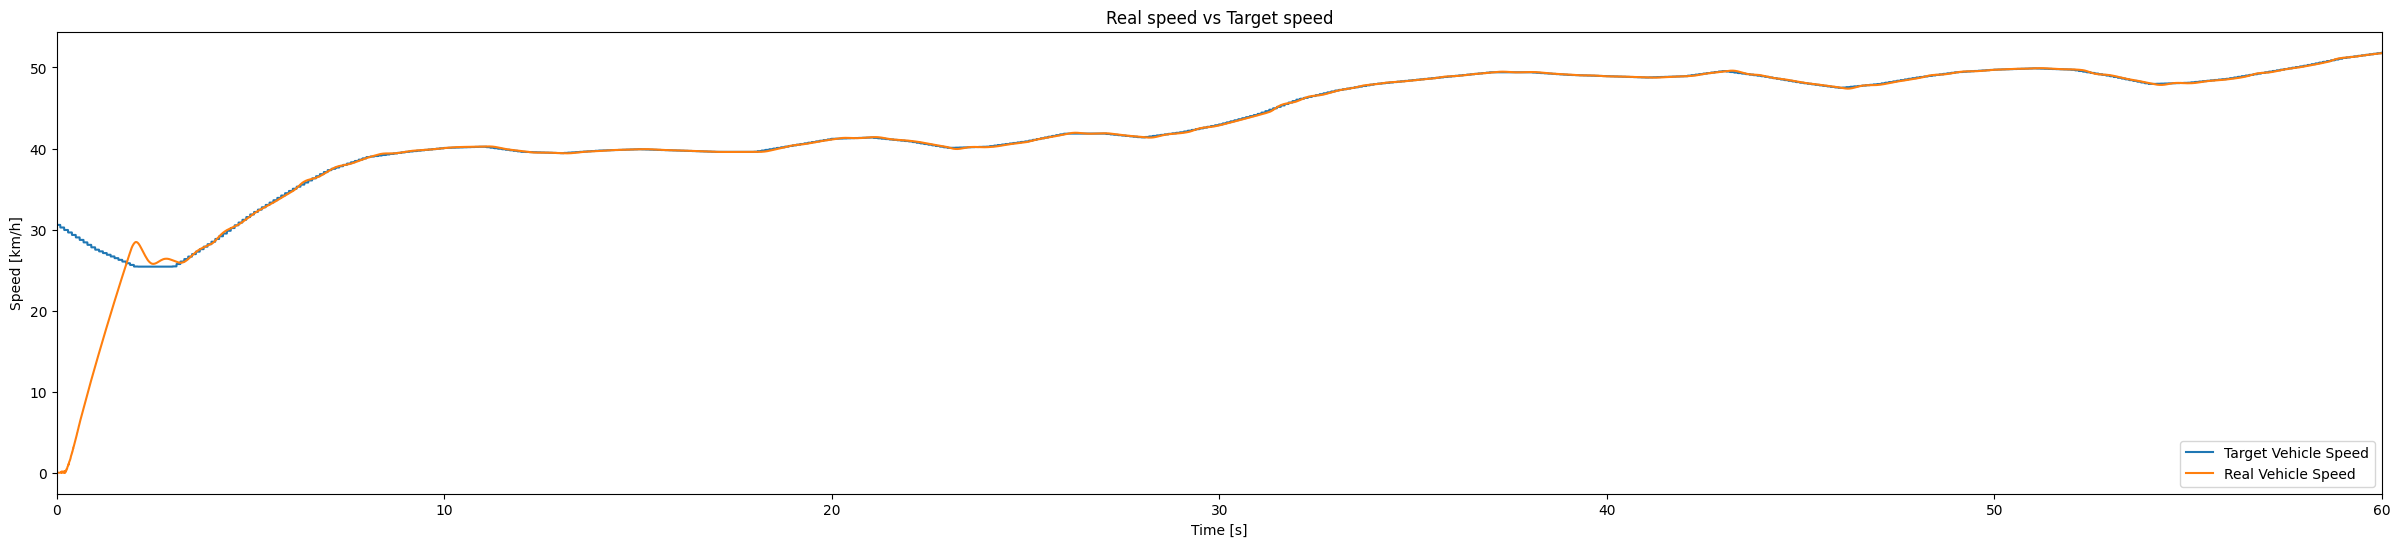

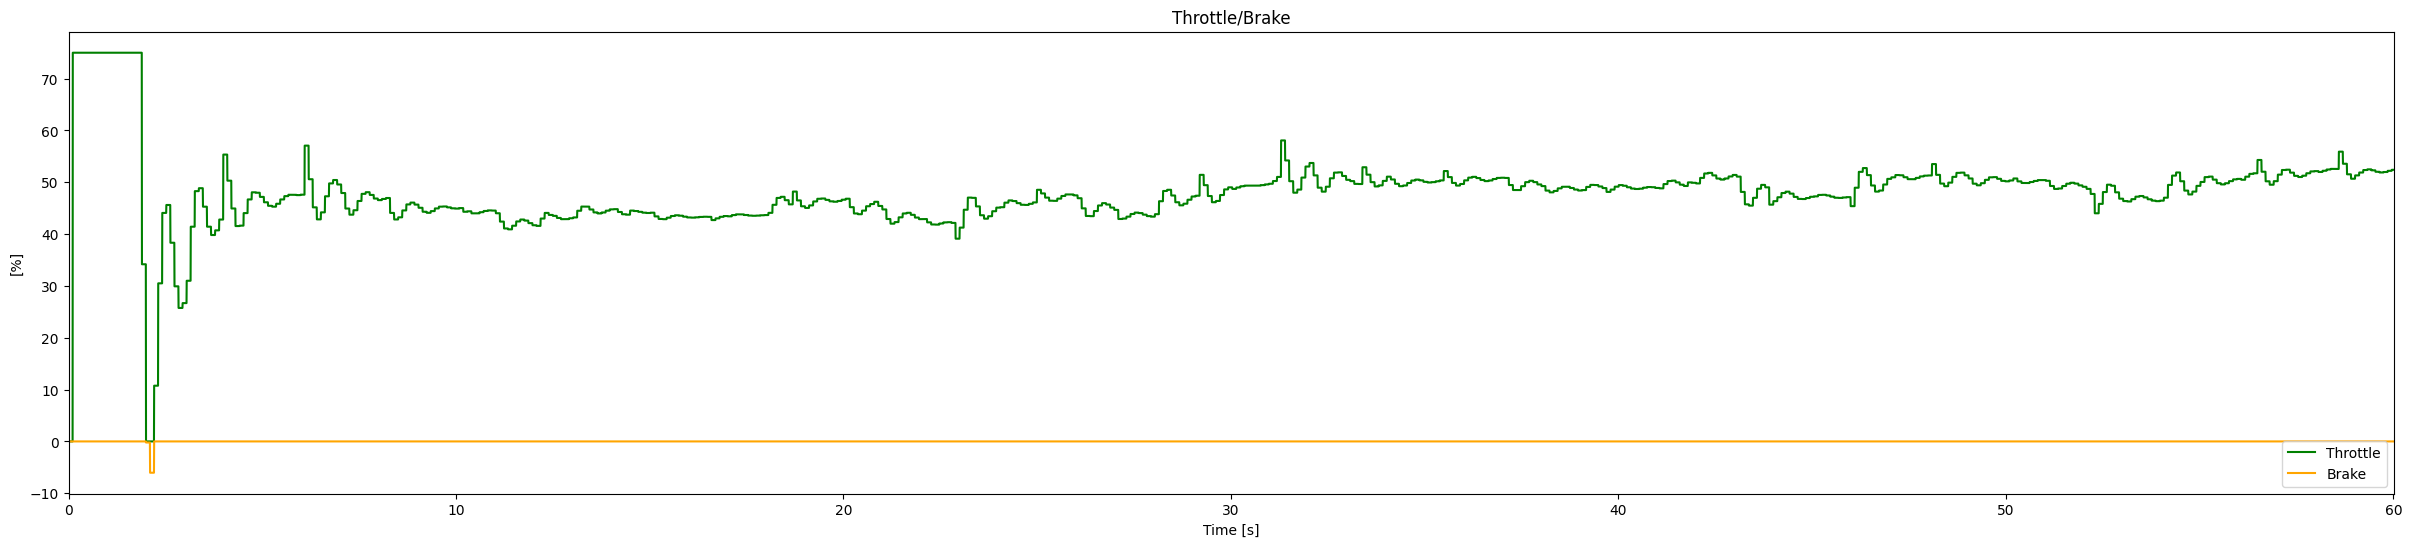

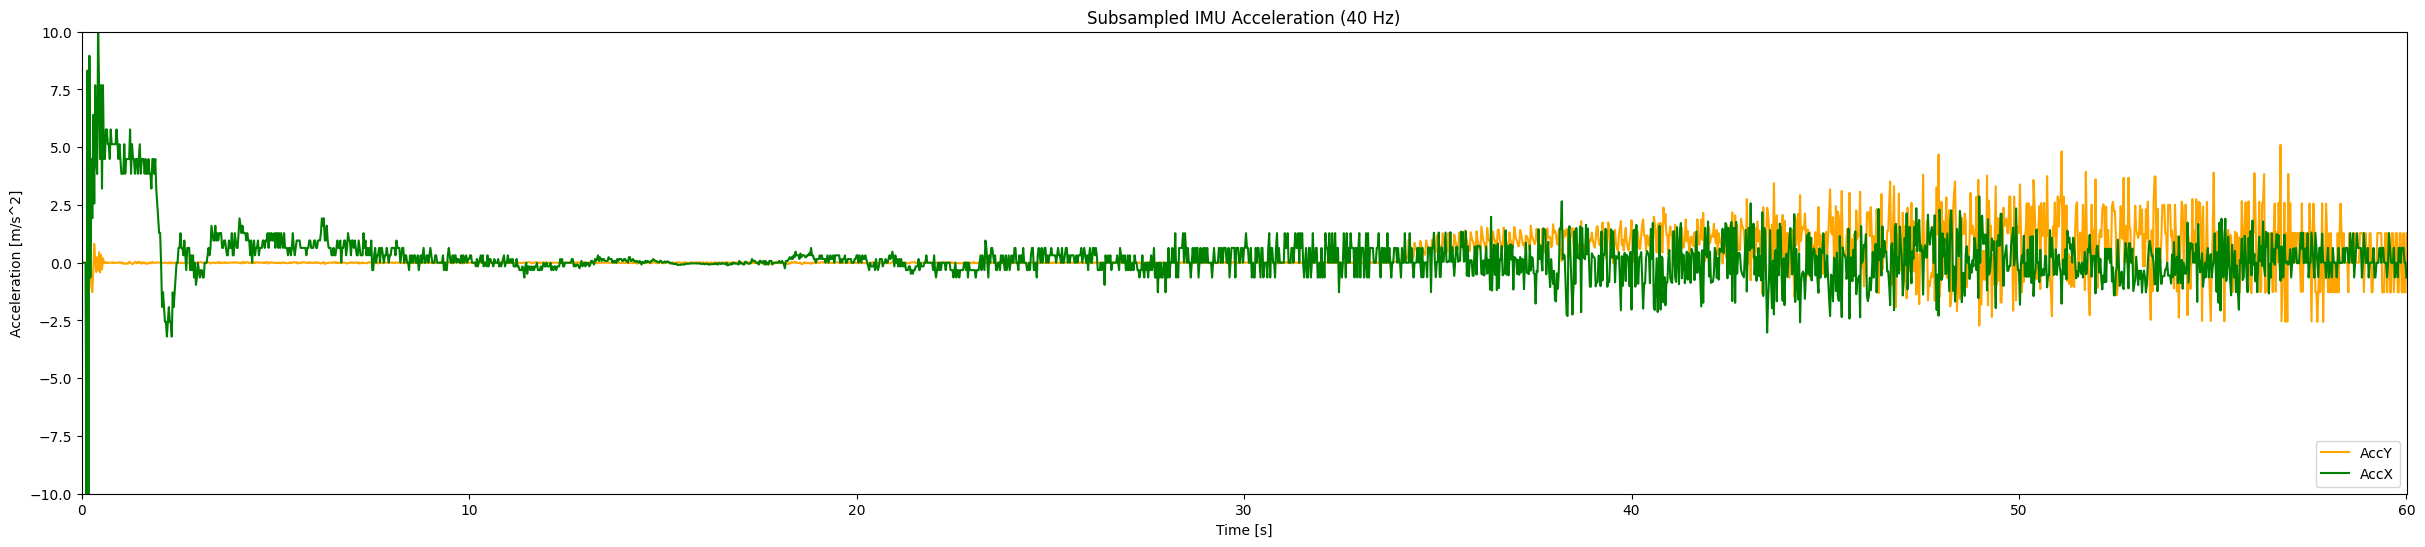

In [17]:
plt.figure(figsize=(30,6))
plt.title("Real speed vs Target speed")
plt.ylabel("Speed [km/h]")
plt.xlabel("Time [s]")
plt.xlim(x_a, x_b)
plt.plot(x_t, y_tv, label='Target Vehicle Speed')
plt.plot(x_t, y_rv, label='Real Vehicle Speed')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(30,6))
plt.title("Throttle/Brake")
plt.ylabel("[%]")
plt.xlabel("Time [s]")
plt.xlim(x_a, x_b)
plt.plot(x_t, 100 * y_tp, label='Throttle', color='green')
plt.plot(x_t, -100 * y_bp, label='Brake', color='orange')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(30,6))
plt.title("Subsampled IMU Acceleration (40 Hz)")
plt.ylabel("Acceleration [m/s^2]")
plt.xlabel("Time [s]")
plt.ylim(-10, 10)
plt.xlim(x_a, x_b)
plt.plot(x_t[::5], acc_y[::5], label='AccY', color='orange')
plt.plot(x_t[::5], acc_x[::5], label='AccX', color='green')
plt.legend(loc="lower right")
plt.show()